https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

# warm up, play with data

In [60]:
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import rand, randn, randint

In [61]:
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


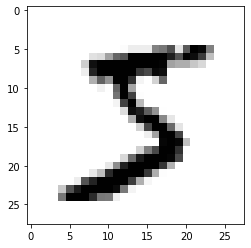

In [62]:
# show one

plt.imshow(trainX[0], cmap='gray_r')
# r means reverse

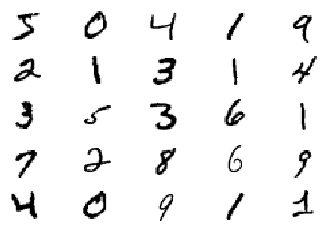

In [63]:
# show more

for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [64]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n, with_channel=True):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        if with_channel:
            # shape = (n_sample, x_axis, y_axis, channel)
            plt.imshow(examples[i, :, :, 0], cmap='gray_r')
        else:
            # shape = (n_sample, x_axis, y_axis)
            plt.imshow(examples[i], cmap='gray_r')
            
    pyplot.show()

In [65]:
# load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = np.expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

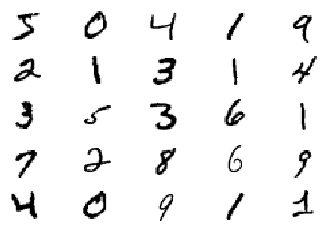

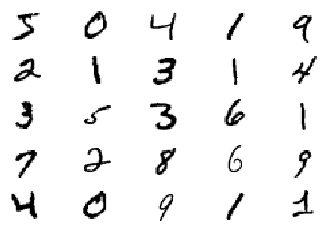

In [66]:
X = load_real_samples()
show_plot(trainX, 5, False)
show_plot(X, 5)

In [67]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

In [68]:

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    
    # generate uniform random numbers in [0,1]
    X = rand(28 * 28 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 28, 28, 1))
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

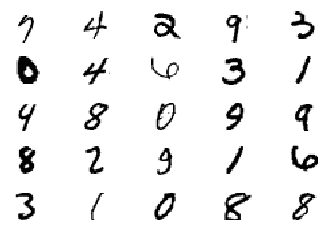

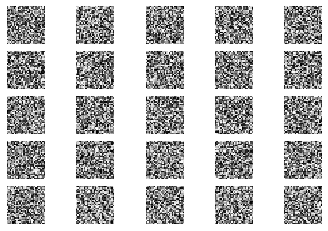

In [69]:
x_real, _ = generate_real_samples(X, 25)
x_fake, _ = generate_fake_samples(25)

show_plot(x_real,5)
show_plot(x_fake,5)


# GAN

In [73]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [74]:
# load image data
dataset = load_real_samples()

In [75]:
def Discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), 
                     strides=(2, 2), 
                     padding='same', 
                     input_shape=in_shape))
    
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), 
                     strides=(2, 2), 
                     padding='same'))
    
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', 
                  optimizer=opt, 
                  metrics=['accuracy'])
    return model
 

In [82]:
def Generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

def generate_task_batch(g_model, dataset, n_samples, latent_dim):
    
    # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # generate 'fake' examples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # create training set for the discriminator
    X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
    
    return X, y


In [83]:
def GAN(g_model, d_model):
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    d_model.trainable = False
    model.add(d_model)
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [84]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, 
          n_epochs=100, 
          n_batch=256):
    
    # n_batch is batch size
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            X, y = generate_task_batch(g_model, 
                                       dataset, 
                                       half_batch, 
                                       latent_dim)
            
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            
            # here is a little bit different than Ivans paper.
            # we did not use the same fake image in task batch:
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, 
                                                  d_loss, 
                                                  g_loss))




In [86]:
# size of the latent space
latent_dim = 100

# create the discriminator
D = Discriminator()
# create the generator
G = Generator(latent_dim)
# create the gan
gan = GAN(G, D)

In [87]:
# train model
train(G, D, gan, dataset, latent_dim, 1, 30)

>1, 1/2000, d=0.693, g=0.724


D:\virtualenvs\congyuml\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/2000, d=0.660, g=0.746
>1, 3/2000, d=0.664, g=0.778
>1, 4/2000, d=0.650, g=0.774
>1, 5/2000, d=0.657, g=0.806
>1, 6/2000, d=0.646, g=0.822
>1, 7/2000, d=0.634, g=0.857
>1, 8/2000, d=0.617, g=0.847
>1, 9/2000, d=0.619, g=0.873
>1, 10/2000, d=0.622, g=0.858
>1, 11/2000, d=0.616, g=0.842
>1, 12/2000, d=0.630, g=0.834
>1, 13/2000, d=0.632, g=0.802
>1, 14/2000, d=0.639, g=0.778
>1, 15/2000, d=0.648, g=0.756
>1, 16/2000, d=0.640, g=0.739
>1, 17/2000, d=0.647, g=0.725
>1, 18/2000, d=0.637, g=0.714
>1, 19/2000, d=0.632, g=0.710
>1, 20/2000, d=0.620, g=0.704
>1, 21/2000, d=0.615, g=0.701
>1, 22/2000, d=0.612, g=0.700
>1, 23/2000, d=0.614, g=0.701
>1, 24/2000, d=0.599, g=0.699
>1, 25/2000, d=0.597, g=0.700
>1, 26/2000, d=0.589, g=0.700
>1, 27/2000, d=0.584, g=0.700
>1, 28/2000, d=0.575, g=0.701
>1, 29/2000, d=0.574, g=0.701
>1, 30/2000, d=0.558, g=0.702
>1, 31/2000, d=0.556, g=0.702
>1, 32/2000, d=0.542, g=0.703
>1, 33/2000, d=0.523, g=0.704
>1, 34/2000, d=0.547, g=0.702
>1, 35/2000, d=0.5

>1, 270/2000, d=0.211, g=1.790
>1, 271/2000, d=0.467, g=1.093
>1, 272/2000, d=2.293, g=0.166
>1, 273/2000, d=2.860, g=0.182
>1, 274/2000, d=1.917, g=1.775
>1, 275/2000, d=1.861, g=1.060
>1, 276/2000, d=2.212, g=0.469
>1, 277/2000, d=2.556, g=0.304
>1, 278/2000, d=2.370, g=0.242
>1, 279/2000, d=2.248, g=0.237
>1, 280/2000, d=2.170, g=0.201
>1, 281/2000, d=1.971, g=0.233
>1, 282/2000, d=1.870, g=0.294
>1, 283/2000, d=1.655, g=0.291
>1, 284/2000, d=1.508, g=0.282
>1, 285/2000, d=1.469, g=0.300
>1, 286/2000, d=1.349, g=0.366
>1, 287/2000, d=1.141, g=0.380
>1, 288/2000, d=1.097, g=0.387
>1, 289/2000, d=1.021, g=0.401
>1, 290/2000, d=1.065, g=0.426
>1, 291/2000, d=1.071, g=0.444
>1, 292/2000, d=1.040, g=0.476
>1, 293/2000, d=0.957, g=0.526
>1, 294/2000, d=0.975, g=0.557
>1, 295/2000, d=0.883, g=0.560
>1, 296/2000, d=0.782, g=0.557
>1, 297/2000, d=0.829, g=0.547
>1, 298/2000, d=0.842, g=0.582
>1, 299/2000, d=0.788, g=0.610
>1, 300/2000, d=0.758, g=0.649
>1, 301/2000, d=0.697, g=0.687
>1, 302/

>1, 535/2000, d=0.737, g=0.695
>1, 536/2000, d=0.765, g=0.673
>1, 537/2000, d=0.769, g=0.681
>1, 538/2000, d=0.687, g=0.641
>1, 539/2000, d=0.720, g=0.631
>1, 540/2000, d=0.711, g=0.665
>1, 541/2000, d=0.736, g=0.721
>1, 542/2000, d=0.734, g=0.685
>1, 543/2000, d=0.813, g=0.696
>1, 544/2000, d=0.747, g=0.735
>1, 545/2000, d=0.693, g=0.705
>1, 546/2000, d=0.726, g=0.671
>1, 547/2000, d=0.677, g=0.707
>1, 548/2000, d=0.751, g=0.675
>1, 549/2000, d=0.740, g=0.688
>1, 550/2000, d=0.730, g=0.691
>1, 551/2000, d=0.734, g=0.665
>1, 552/2000, d=0.766, g=0.681
>1, 553/2000, d=0.691, g=0.686
>1, 554/2000, d=0.732, g=0.698
>1, 555/2000, d=0.723, g=0.723
>1, 556/2000, d=0.710, g=0.732
>1, 557/2000, d=0.778, g=0.753
>1, 558/2000, d=0.729, g=0.716
>1, 559/2000, d=0.817, g=0.685
>1, 560/2000, d=0.728, g=0.692
>1, 561/2000, d=0.728, g=0.715
>1, 562/2000, d=0.740, g=0.720
>1, 563/2000, d=0.692, g=0.703
>1, 564/2000, d=0.779, g=0.771
>1, 565/2000, d=0.688, g=0.686
>1, 566/2000, d=0.706, g=0.646
>1, 567/

>1, 800/2000, d=0.712, g=0.684
>1, 801/2000, d=0.718, g=0.702
>1, 802/2000, d=0.737, g=0.661
>1, 803/2000, d=0.708, g=0.706
>1, 804/2000, d=0.679, g=0.688
>1, 805/2000, d=0.686, g=0.626
>1, 806/2000, d=0.736, g=0.651
>1, 807/2000, d=0.722, g=0.686
>1, 808/2000, d=0.702, g=0.701
>1, 809/2000, d=0.738, g=0.674
>1, 810/2000, d=0.701, g=0.697
>1, 811/2000, d=0.717, g=0.688
>1, 812/2000, d=0.719, g=0.736
>1, 813/2000, d=0.723, g=0.694
>1, 814/2000, d=0.697, g=0.687
>1, 815/2000, d=0.768, g=0.684
>1, 816/2000, d=0.764, g=0.663
>1, 817/2000, d=0.712, g=0.696
>1, 818/2000, d=0.787, g=0.689
>1, 819/2000, d=0.737, g=0.706
>1, 820/2000, d=0.737, g=0.745
>1, 821/2000, d=0.742, g=0.730
>1, 822/2000, d=0.725, g=0.720
>1, 823/2000, d=0.734, g=0.712
>1, 824/2000, d=0.767, g=0.737
>1, 825/2000, d=0.754, g=0.743
>1, 826/2000, d=0.693, g=0.751
>1, 827/2000, d=0.751, g=0.707
>1, 828/2000, d=0.728, g=0.697
>1, 829/2000, d=0.715, g=0.678
>1, 830/2000, d=0.730, g=0.623
>1, 831/2000, d=0.716, g=0.667
>1, 832/

>1, 1063/2000, d=0.699, g=0.672
>1, 1064/2000, d=0.696, g=0.715
>1, 1065/2000, d=0.681, g=0.675
>1, 1066/2000, d=0.721, g=0.721
>1, 1067/2000, d=0.719, g=0.742
>1, 1068/2000, d=0.641, g=0.726
>1, 1069/2000, d=0.697, g=0.727
>1, 1070/2000, d=0.681, g=0.726
>1, 1071/2000, d=0.668, g=0.731
>1, 1072/2000, d=0.699, g=0.689
>1, 1073/2000, d=0.689, g=0.725
>1, 1074/2000, d=0.701, g=0.771
>1, 1075/2000, d=0.733, g=0.728
>1, 1076/2000, d=0.734, g=0.770
>1, 1077/2000, d=0.682, g=0.708
>1, 1078/2000, d=0.659, g=0.719
>1, 1079/2000, d=0.722, g=0.718
>1, 1080/2000, d=0.715, g=0.721
>1, 1081/2000, d=0.681, g=0.739
>1, 1082/2000, d=0.731, g=0.731
>1, 1083/2000, d=0.722, g=0.713
>1, 1084/2000, d=0.654, g=0.746
>1, 1085/2000, d=0.690, g=0.741
>1, 1086/2000, d=0.678, g=0.690
>1, 1087/2000, d=0.709, g=0.732
>1, 1088/2000, d=0.679, g=0.676
>1, 1089/2000, d=0.655, g=0.684
>1, 1090/2000, d=0.683, g=0.684
>1, 1091/2000, d=0.650, g=0.693
>1, 1092/2000, d=0.730, g=0.702
>1, 1093/2000, d=0.690, g=0.688
>1, 1094

>1, 1320/2000, d=0.680, g=0.757
>1, 1321/2000, d=0.698, g=0.753
>1, 1322/2000, d=0.710, g=0.747
>1, 1323/2000, d=0.657, g=0.746
>1, 1324/2000, d=0.672, g=0.751
>1, 1325/2000, d=0.661, g=0.736
>1, 1326/2000, d=0.655, g=0.726
>1, 1327/2000, d=0.654, g=0.727
>1, 1328/2000, d=0.663, g=0.693
>1, 1329/2000, d=0.710, g=0.701
>1, 1330/2000, d=0.653, g=0.705
>1, 1331/2000, d=0.620, g=0.671
>1, 1332/2000, d=0.642, g=0.671
>1, 1333/2000, d=0.653, g=0.684
>1, 1334/2000, d=0.673, g=0.714
>1, 1335/2000, d=0.661, g=0.688
>1, 1336/2000, d=0.703, g=0.692
>1, 1337/2000, d=0.697, g=0.723
>1, 1338/2000, d=0.697, g=0.758
>1, 1339/2000, d=0.691, g=0.745
>1, 1340/2000, d=0.657, g=0.746
>1, 1341/2000, d=0.650, g=0.797
>1, 1342/2000, d=0.653, g=0.822
>1, 1343/2000, d=0.673, g=0.827
>1, 1344/2000, d=0.687, g=0.838
>1, 1345/2000, d=0.673, g=0.818
>1, 1346/2000, d=0.660, g=0.793
>1, 1347/2000, d=0.689, g=0.772
>1, 1348/2000, d=0.696, g=0.779
>1, 1349/2000, d=0.711, g=0.717
>1, 1350/2000, d=0.705, g=0.710
>1, 1351

>1, 1577/2000, d=0.701, g=0.687
>1, 1578/2000, d=0.707, g=0.723
>1, 1579/2000, d=0.687, g=0.661
>1, 1580/2000, d=0.685, g=0.651
>1, 1581/2000, d=0.702, g=0.704
>1, 1582/2000, d=0.684, g=0.690
>1, 1583/2000, d=0.674, g=0.669
>1, 1584/2000, d=0.674, g=0.666
>1, 1585/2000, d=0.670, g=0.689
>1, 1586/2000, d=0.684, g=0.707
>1, 1587/2000, d=0.694, g=0.717
>1, 1588/2000, d=0.698, g=0.707
>1, 1589/2000, d=0.693, g=0.757
>1, 1590/2000, d=0.688, g=0.716
>1, 1591/2000, d=0.707, g=0.741
>1, 1592/2000, d=0.663, g=0.737
>1, 1593/2000, d=0.662, g=0.788
>1, 1594/2000, d=0.680, g=0.772
>1, 1595/2000, d=0.641, g=0.798
>1, 1596/2000, d=0.682, g=0.802
>1, 1597/2000, d=0.693, g=0.788
>1, 1598/2000, d=0.674, g=0.787
>1, 1599/2000, d=0.639, g=0.792
>1, 1600/2000, d=0.721, g=0.760
>1, 1601/2000, d=0.657, g=0.770
>1, 1602/2000, d=0.675, g=0.726
>1, 1603/2000, d=0.684, g=0.706
>1, 1604/2000, d=0.688, g=0.721
>1, 1605/2000, d=0.665, g=0.685
>1, 1606/2000, d=0.701, g=0.720
>1, 1607/2000, d=0.687, g=0.682
>1, 1608

>1, 1834/2000, d=0.703, g=0.749
>1, 1835/2000, d=0.678, g=0.737
>1, 1836/2000, d=0.690, g=0.757
>1, 1837/2000, d=0.634, g=0.716
>1, 1838/2000, d=0.639, g=0.726
>1, 1839/2000, d=0.643, g=0.713
>1, 1840/2000, d=0.672, g=0.713
>1, 1841/2000, d=0.658, g=0.702
>1, 1842/2000, d=0.609, g=0.733
>1, 1843/2000, d=0.663, g=0.697
>1, 1844/2000, d=0.653, g=0.680
>1, 1845/2000, d=0.677, g=0.685
>1, 1846/2000, d=0.641, g=0.683
>1, 1847/2000, d=0.674, g=0.690
>1, 1848/2000, d=0.695, g=0.709
>1, 1849/2000, d=0.672, g=0.727
>1, 1850/2000, d=0.682, g=0.789
>1, 1851/2000, d=0.675, g=0.764
>1, 1852/2000, d=0.658, g=0.854
>1, 1853/2000, d=0.624, g=0.883
>1, 1854/2000, d=0.646, g=0.860
>1, 1855/2000, d=0.646, g=0.869
>1, 1856/2000, d=0.619, g=0.861
>1, 1857/2000, d=0.647, g=0.840
>1, 1858/2000, d=0.668, g=0.788
>1, 1859/2000, d=0.666, g=0.752
>1, 1860/2000, d=0.685, g=0.718
>1, 1861/2000, d=0.675, g=0.678
>1, 1862/2000, d=0.713, g=0.639
>1, 1863/2000, d=0.697, g=0.644
>1, 1864/2000, d=0.691, g=0.667
>1, 1865

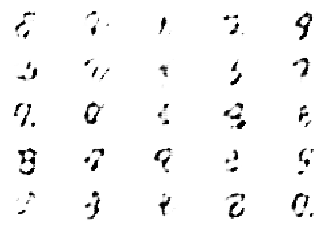

In [92]:
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = G.predict(latent_points)

# plot the result
show_plot(X, 5)

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis   
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()